# *E. coli* Live Simulation Notebook

## Setup Simulation

In [18]:
import os
import sys
import datetime

WC_ECOLI_DIRECTORY = os.path.expanduser("~/wcEcoli")
OUT_DIRECTORY = os.path.join(WC_ECOLI_DIRECTORY, "out")

now = datetime.datetime.now()
SUBMISSION_TIME = "%04d%02d%02d.%02d%02d%02d.%06d" % (
	now.year, now.month, now.day,
	now.hour, now.minute, now.second,
	now.microsecond)

JUPYTER_OUT_DIR = "jupyter"
KB_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "kb")
METADATA_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "metadata")
CELL_DIRECTORY = os.path.join(OUT_DIRECTORY, JUPYTER_OUT_DIR, "wildtype_000000", "000000", "generation_000000", "000000")
SIM_DATA_PATH = os.path.join(KB_DIRECTORY, "simData_Fit_1.cPickle")
SIM_OUT_PATH = os.path.join(CELL_DIRECTORY, "simOut")
PLOT_OUT_PATH = os.path.join(CELL_DIRECTORY, "plotOut")

if not os.path.exists(KB_DIRECTORY):
    os.makedirs(KB_DIRECTORY)

if not os.path.exists(METADATA_DIRECTORY):
    os.makedirs(METADATA_DIRECTORY)
    
if not os.path.exists(CELL_DIRECTORY):
    os.makedirs(CELL_DIRECTORY)
    
if not os.path.exists(SIM_OUT_PATH):
    os.makedirs(SIM_OUT_PATH)
    
if not os.path.exists(PLOT_OUT_PATH):
    os.makedirs(PLOT_OUT_PATH)

sys.path.append(WC_ECOLI_DIRECTORY)

Load and fit the data.

In [2]:
import cPickle
from reconstruction.ecoli.knowledge_base_raw import KnowledgeBaseEcoli
from reconstruction.ecoli.fit_sim_data_1 import fitSimData_1
from reconstruction.ecoli.fit_sim_data_2 import fitSimData_2

raw_data = KnowledgeBaseEcoli()
sim_data = fitSimData_1(raw_data)

with open(SIM_DATA_PATH, 'wb') as f:
    cPickle.dump(sim_data, f, cPickle.HIGHEST_PROTOCOL)

/share/PI/mcovert/pyenv/versions/wcEcoli/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [116]:
from models.ecoli.sim.simulation import EcoliSimulation

class EcoliLiveSimulation(EcoliSimulation):
    def startup(self):
        # Perform initial mass calculations
        for state in self.states.itervalues():
            state.calculatePreEvolveStateMass()
            state.calculatePostEvolveStateMass()

        # Perform initial listener update
        for listener in self.listeners.itervalues():
            listener.initialUpdate()

        # Start logging
        for logger in self.loggers.itervalues():
            logger.initialize(self)
            
    def step(self, steps=1, time=None):
        startTime = self._timeTotal
        stepCount = 0
        
        while True:
            stepCount += 1
            
            if steps > 0 and stepCount > steps:
                break
            
            if time is not None and startTime + time < self._timeTotal:
                break
            
            if self._cellCycleComplete:
                print "Cell cycle complete"
                break

            self._simulationStep += 1
            self._timeTotal += self._timeStepSec
            self._evolveState()
        
        self._syncwrites()
            
    def _syncwrites(self):
        # If python didn't want OO-breaking manipulation of private data,
        # it would have had visibility specification.

        for obj, saveFile in dict(self.loggers['Disk'].saveFiles, mainFile=self.loggers['Disk'].mainFile).iteritems():
            if saveFile._columns is not None:
                for name, column in saveFile._columns.iteritems():
                    column._data.flush()
                    column._offsets.flush()
                    os.fsync(column._data)
                    os.fsync(column._offsets)
    
    def shutdown(self):
        # Run post-simulation hooks
        for hook in self.hooks.itervalues():
            hook.finalize(self)

        # Divide mother into daughter cells
        self._divideCellFunction()

        # Finish logging
        for logger in self.loggers.itervalues():
            logger.finalize(self)

In [117]:
options = {}

options["simDataLocation"] = SIM_DATA_PATH
options["outputDir"] = os.path.join(CELL_DIRECTORY, "simOut")
options["logToDisk"] = True
options["overwriteExistingFiles"] = False

sim = EcoliLiveSimulation(**options)

In [118]:
sim.startup()

Time (s)  Dry mass     Dry mass      Protein          RNA     Expected
              (fg)  fold change  fold change  fold change  fold change
========  ========  ===========  ===========  ===========  ===========
       0    245.46        1.000        1.000        1.000        1.000


In [131]:
sim.step(steps=0, time=5)

      89    252.87        1.030        1.018        1.012        1.017
      90    252.93        1.030        1.019        1.012        1.018
      91    252.99        1.031        1.019        1.013        1.018
      91    253.05        1.031        1.019        1.013        1.018
      92    253.11        1.031        1.019        1.013        1.018
      93    253.17        1.031        1.019        1.013        1.018


In [141]:
b = sim.states['BulkMolecules']
b.container.counts()

array([0, 0, 0, ..., 0, 0, 0])

In [109]:
sim.shutdown()


Simulation finished:
 - Length: 0:00:21
 - Runtime: 0:00:37



In [97]:
import importlib

def analyse(plot):
    mod = importlib.import_module("models.ecoli.analysis.single." + plot)
    mod.main(SIM_OUT_PATH, PLOT_OUT_PATH, plot, SIM_DATA_PATH, None, None)
    return SVG(filename=os.path.join(PLOT_OUT_PATH, "svg_plots", "%s.svg" % plot))

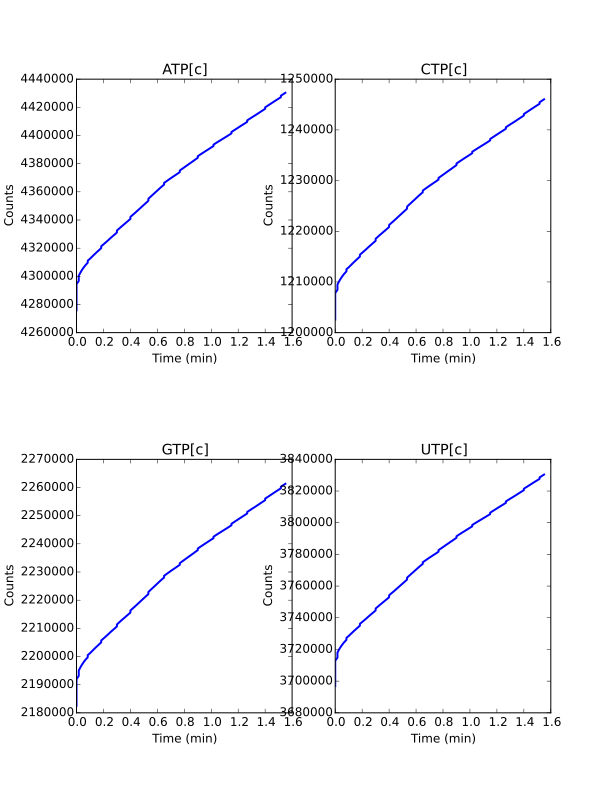

In [144]:
analyse("ntpCounts")